# **SET-UP**

In this section, the relavant libraries are imported, and the training, validation and test datasets are prepared.

If the notebook is running on Google Colab, the data can be downloaded to the environment by running the corresponding cell.

In [1]:
# imports

import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import cv2
from PIL import Image

### Download Data into Google Colab Environment

This cell should only be executed if the notebook is running on Google Colab.

If the notebook is running locally with the data already situated in the correct directory, this cell block should **not** be run.

In [2]:
# download if zip files not already downloaded
if not os.path.exists('data.zip'):
    !gdown '1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW'
else:
    print('data.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('data'):
    !unzip -qq data.zip
    !rm data.zip
else:
    print('data folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW
From (redirected): https://drive.google.com/uc?id=1KCEr8wD4vGuYhop8ShshLFPnx-3wzeSW&confirm=t&uuid=911916c4-bf16-421d-9f75-313b011696df
To: /content/data.zip
100% 289M/289M [00:02<00:00, 136MB/s]


In [3]:
# download if zip files not already downloaded
if not os.path.exists('utils.zip'):
    !gdown '1x402dUiBIKfrkBgzd-nbnZDdP1a_tTs4'
else:
    print('utils.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('utils'):
    !unzip -qq utils.zip
    !rm utils.zip
else:
    print('utils folder already exists')

Downloading...
From: https://drive.google.com/uc?id=1x402dUiBIKfrkBgzd-nbnZDdP1a_tTs4
To: /content/utils.zip
100% 1.79k/1.79k [00:00<00:00, 8.85MB/s]


In [4]:
# download if zip files not already downloaded
if not os.path.exists('depth_estimation.zip'):
    !gdown '1aNww-oYs-eObTImT923rFejQDDLsfOI6'
else:
    print('depth_estimation.zip already exists')

# unzip if folders don't already exist
if not os.path.exists('depth_estimation'):
    !unzip -qq depth_estimation.zip
    !rm depth_estimation.zip
else:
    print('depth_estimation folder already exists')

Downloading...
From (original): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6
From (redirected): https://drive.google.com/uc?id=1aNww-oYs-eObTImT923rFejQDDLsfOI6&confirm=t&uuid=9f3a9f08-4061-4c4a-b0e9-7798a97f1142
To: /content/depth_estimation.zip
100% 55.4M/55.4M [00:00<00:00, 106MB/s]


## Constructing Datasets

Informally experimenting with various batch sizes,demonstrated that a batch size of four yielded the best results.

In [5]:
# batch size
B = 4

The appropriate transformations can be applied for training, validation and test data. The dataset is split into 60% for training data, 10% for validation data, and 30% for test data.

In [6]:
from torch.utils.data import random_split, DataLoader
from utils.seq_dataset import SeqDataset
from utils.data_management import get_transform, initialize_loader

# set up dataset
dataset = SeqDataset(root_dir='data', transform=None)

# picking out the sizes
train_size = int(0.6 * len(dataset))              # 60% for training
val_size = int(0.1 * len(dataset))                # 10% for validation
test_size = len(dataset) - train_size - val_size  # 30 for testing

# split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# dataloaders
train_loader = initialize_loader(train_dataset, get_transform("train"), B, True)
val_loader = initialize_loader(val_dataset, get_transform("validation"), B, False)
test_loader = initialize_loader(test_dataset, get_transform("test"), B, False)

### Visualize Data

This cell can be optionally executed to visualize the structure of the dataset.

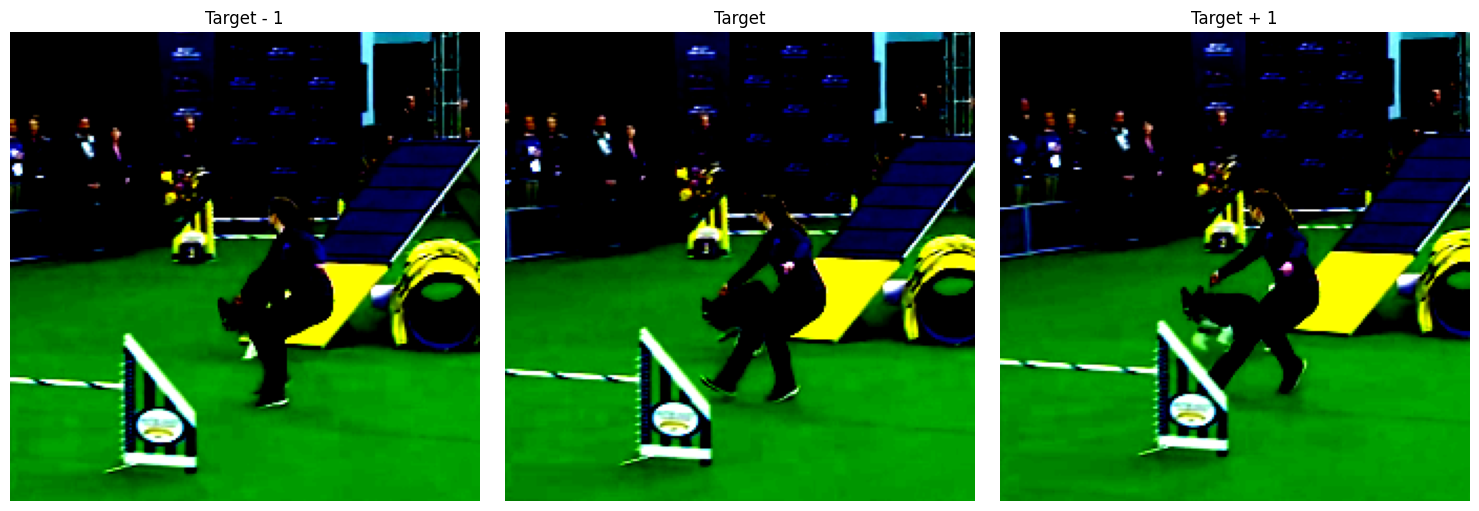

In [7]:
tgt, [s1, s2] = train_dataset[10]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Target - 1")
plt.imshow(s1.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Target")
plt.imshow(tgt.permute(1, 2, 0).numpy())
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target + 1")
plt.imshow(s2.permute(1, 2, 0).numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

# **TRAINING**

In [8]:
from object_detector import ObjSegmentation
from segmentation_trainer import SegmentationTrainer
from utils.visual_helpers import plot_train_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Pretrained Models

In [9]:
# load pretrained dino for backbone feature detector
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
feat_dim = 768  # fixed value

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s]


In [10]:
from depth_estimation.depth_net import DepthNet
from depth_estimation.pose_net import PoseNet

depth_net = DepthNet().to(device)
pose_net = PoseNet().to(device)

depth_net.load_state_dict(torch.load("depth_estimation/weights/depth_D_weights.pth", map_location=torch.device('cpu')))
pose_net.load_state_dict(torch.load("depth_estimation/weights/pose_D_weights.pth", map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


<All keys matched successfully>

## Version A: Solo Training the Object Segmentation Module

### LR = 1e-4

In [11]:
solo_obj_detector_a = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(solo_obj_detector_a.parameters(), lr=1e-4)
solo_trainer_a = SegmentationTrainer(solo_obj_detector_a, optimizer, train_loader, device, dino=dino, epochs=50)

In [12]:
solo_trainer_a.train()


EPOCH 1 -----------------------------
[average loss: 0.7445]

EPOCH 2 -----------------------------
[average loss: 0.7364]

EPOCH 3 -----------------------------
[average loss: 0.7353]

EPOCH 4 -----------------------------
[average loss: 0.7347]

EPOCH 5 -----------------------------
[average loss: 0.7341]

EPOCH 6 -----------------------------
[average loss: 0.7339]

EPOCH 7 -----------------------------
[average loss: 0.7337]

EPOCH 8 -----------------------------
[average loss: 0.7335]

EPOCH 9 -----------------------------
[average loss: 0.7335]

EPOCH 10 -----------------------------
[average loss: 0.7332]

EPOCH 11 -----------------------------
[average loss: 0.7331]

EPOCH 12 -----------------------------
[average loss: 0.7332]

EPOCH 13 -----------------------------
[average loss: 0.7329]

EPOCH 14 -----------------------------
[average loss: 0.7328]

EPOCH 15 -----------------------------
[average loss: 0.7327]

EPOCH 16 -----------------------------
[average loss: 0.7327]



### LR = 1e-3

In [24]:
solo_obj_detector_b = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(solo_obj_detector_b.parameters(), lr=1e-3)
solo_trainer_b = SegmentationTrainer(solo_obj_detector_b, optimizer, train_loader, device, dino=dino, epochs=50)

In [25]:
solo_trainer_b.train()


EPOCH 1 -----------------------------
[average loss: 0.7457]

EPOCH 2 -----------------------------
[average loss: 0.7365]

EPOCH 3 -----------------------------
[average loss: 0.7352]

EPOCH 4 -----------------------------
[average loss: 0.7348]

EPOCH 5 -----------------------------
[average loss: 0.7342]

EPOCH 6 -----------------------------
[average loss: 0.7341]

EPOCH 7 -----------------------------
[average loss: 0.7339]

EPOCH 8 -----------------------------
[average loss: 0.7341]

EPOCH 9 -----------------------------
[average loss: 0.7339]

EPOCH 10 -----------------------------
[average loss: 0.7336]

EPOCH 11 -----------------------------
[average loss: 0.7336]

EPOCH 12 -----------------------------
[average loss: 0.7336]

EPOCH 13 -----------------------------
[average loss: 0.7333]

EPOCH 14 -----------------------------
[average loss: 0.7336]

EPOCH 15 -----------------------------
[average loss: 0.7334]

EPOCH 16 -----------------------------
[average loss: 0.7332]



### LR = 1e-2

In [30]:
solo_obj_detector_c = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(solo_obj_detector_c.parameters(), lr=1e-2)
solo_trainer_c = SegmentationTrainer(solo_obj_detector_c, optimizer, train_loader, device, dino=dino, epochs=50)

In [31]:
solo_trainer_c.train()


EPOCH 1 -----------------------------
[average loss: 1.1932]

EPOCH 2 -----------------------------
[average loss: 1.1941]

EPOCH 3 -----------------------------
[average loss: 1.1941]

EPOCH 4 -----------------------------
[average loss: 1.1941]

EPOCH 5 -----------------------------
[average loss: 1.1941]

EPOCH 6 -----------------------------
[average loss: 1.1941]

EPOCH 7 -----------------------------
[average loss: 1.1941]

EPOCH 8 -----------------------------
[average loss: 1.1941]

EPOCH 9 -----------------------------
[average loss: 1.1941]

EPOCH 10 -----------------------------
[average loss: 1.1941]

EPOCH 11 -----------------------------
[average loss: 1.1941]

EPOCH 12 -----------------------------
[average loss: 1.1941]

EPOCH 13 -----------------------------
[average loss: 1.1941]

EPOCH 14 -----------------------------
[average loss: 1.1941]

EPOCH 15 -----------------------------
[average loss: 1.1941]

EPOCH 16 -----------------------------
[average loss: 1.1941]



## Version B: Training with a Pretrained Depth Estimator

### LR = 5e-4

In [ ]:
wd_obj_detector_a = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(wd_obj_detector_a.parameters(), lr=5e-4)
wd_trainer_a = SegmentationTrainer(wd_obj_detector_a, optimizer, train_loader, device, depth_net=depth_net, dino=dino, epochs=50)

In [ ]:
wd_trainer_a.train()


EPOCH 1 -----------------------------
[average loss: 0.7496]

EPOCH 2 -----------------------------
[average loss: 0.7425]

EPOCH 3 -----------------------------
[average loss: 0.7416]

EPOCH 4 -----------------------------
[average loss: 0.7412]

EPOCH 5 -----------------------------
[average loss: 0.7410]

EPOCH 6 -----------------------------
[average loss: 0.7408]

EPOCH 7 -----------------------------
[average loss: 0.7406]

EPOCH 8 -----------------------------
[average loss: 0.7405]

EPOCH 9 -----------------------------
[average loss: 0.7404]

EPOCH 10 -----------------------------
[average loss: 0.7403]

EPOCH 11 -----------------------------
[average loss: 0.7403]

EPOCH 12 -----------------------------
[average loss: 0.7402]

EPOCH 13 -----------------------------
[average loss: 0.7402]

EPOCH 14 -----------------------------
[average loss: 0.7401]

EPOCH 15 -----------------------------
[average loss: 0.7401]

EPOCH 16 -----------------------------
[average loss: 0.7401]



### LR = 5e-3

In [ ]:
wd_obj_detector_b = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(wd_obj_detector_b.parameters(), lr=5e-3)
wd_trainer_b = SegmentationTrainer(wd_obj_detector_b, optimizer, train_loader, device, depth_net=depth_net, dino=dino, epochs=50)

In [ ]:
wd_trainer_b.train()

### LR = 1e-2

In [ ]:
wd_obj_detector_c = ObjSegmentation(feat_dim).to(device)
optimizer = torch.optim.Adam(wd_obj_detector_c.parameters(), lr=5e-2)
wd_trainer_c = SegmentationTrainer(wd_obj_detector_c, optimizer, train_loader, device, depth_net=depth_net, dino=dino, epochs=50)

In [ ]:
wd_trainer_c.train()

## Version C: Joint Training with Untrained Depth Estimator

### LR = 1e-3

### LR = 5e-3

### LR = 1e-2

## Analysis: Pretrained vs Joint Training Loss Over Epochs


#### Version A: Solo

##### **LR = 1e-4**

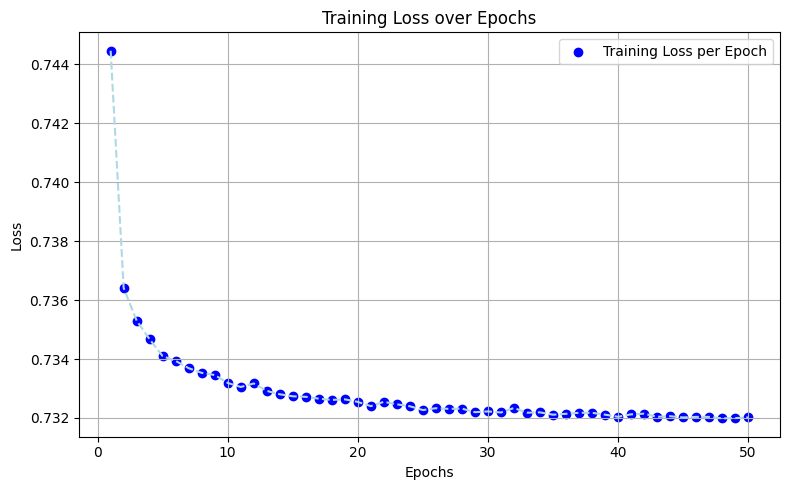

In [13]:
plot_train_loss(solo_trainer_a, 50)

##### **LR = 1e-3**

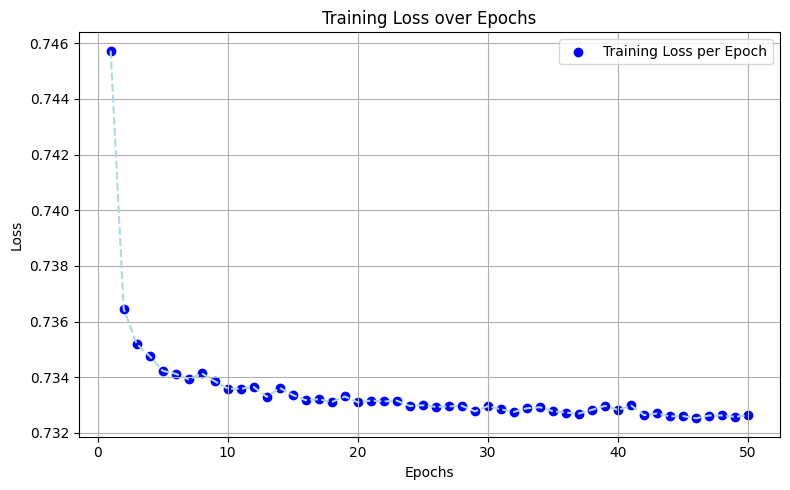

In [26]:
plot_train_loss(solo_trainer_b, 50)

##### **LR = 1e-2**

This learning rate is too large

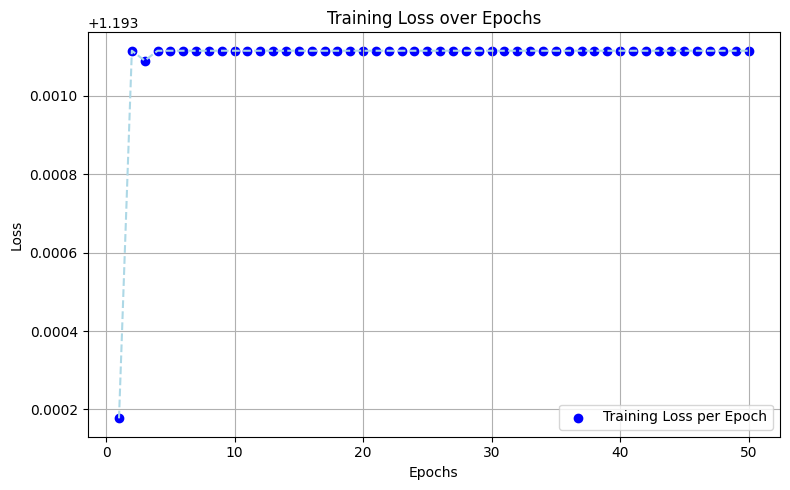

In [33]:
plot_train_loss(solo_trainer_c, 50)

#### Version B: With Pretrained Depth

##### **LR = 5e-4**

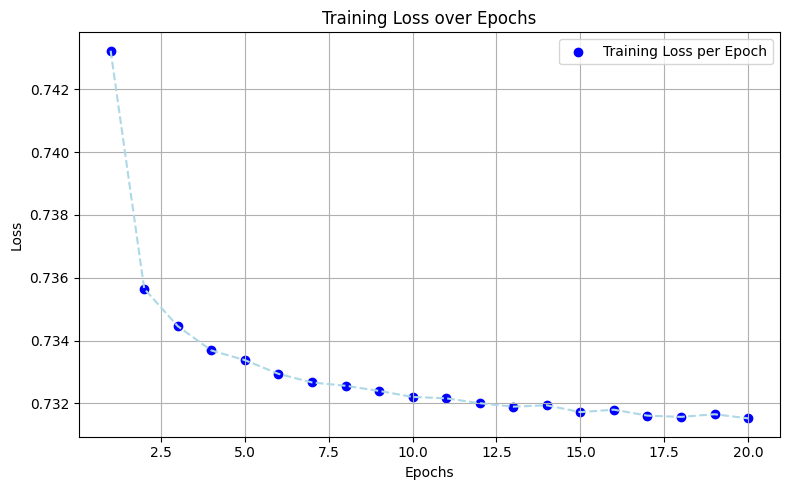

In [ ]:
plot_train_loss(wd_trainer_a, 50)

##### **LR = 5e-3**

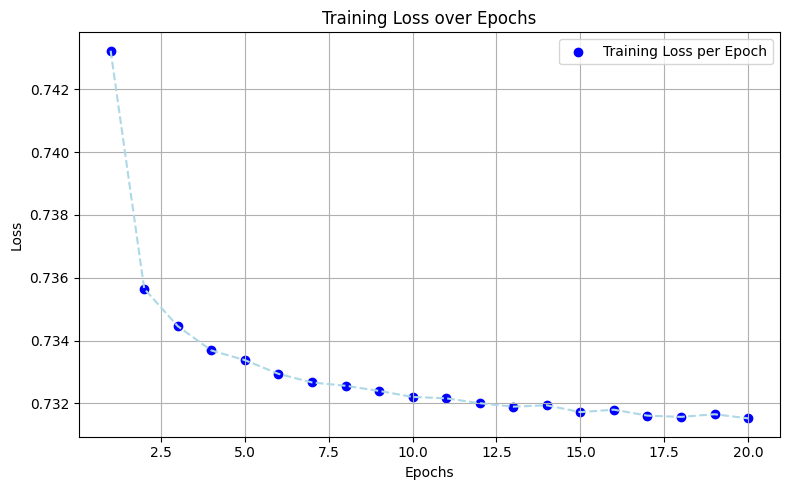

In [ ]:
plot_train_loss(wd_trainer_b, 50)

##### **LR = 1e-2**

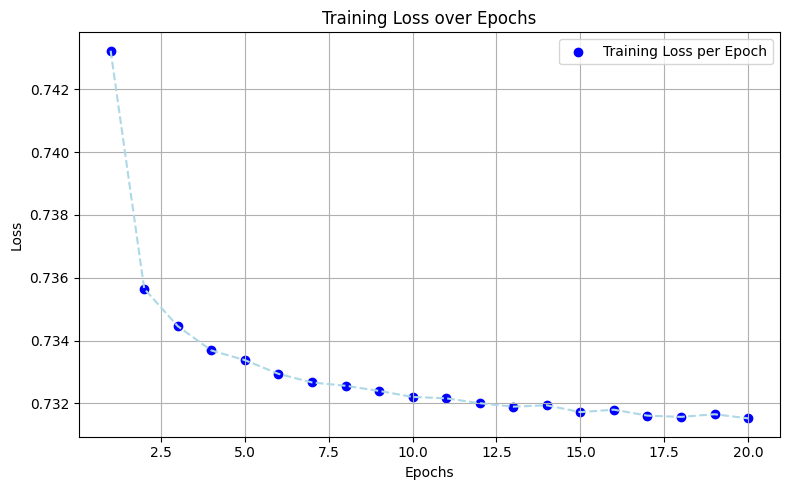

In [ ]:
plot_train_loss(wd_trainer_c, 50)

### Version C: Joint

##### **LR = 1e-3**

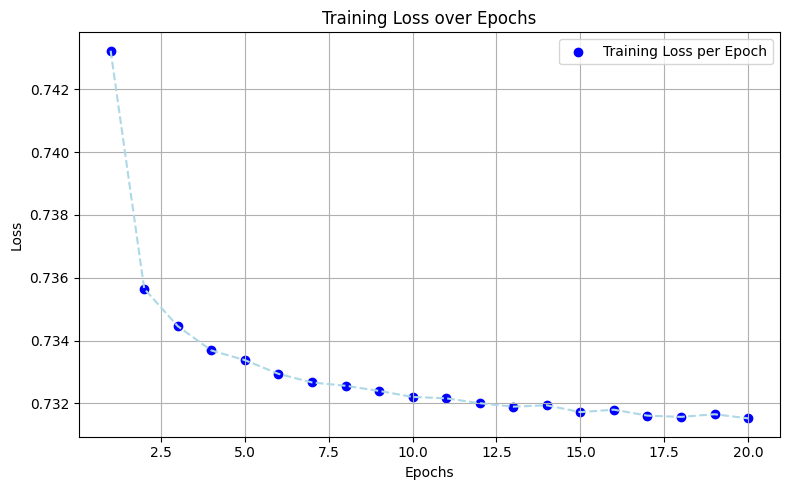

In [ ]:
plot_train_loss(solo_trainer_a, 50)

##### **LR = 5e-3**

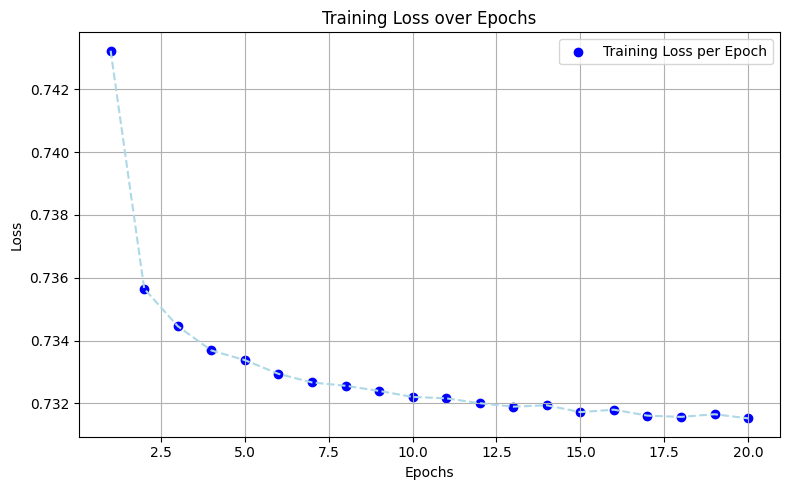

In [ ]:
plot_train_loss(solo_trainer_a, 50)

##### **LR = 1e-2**

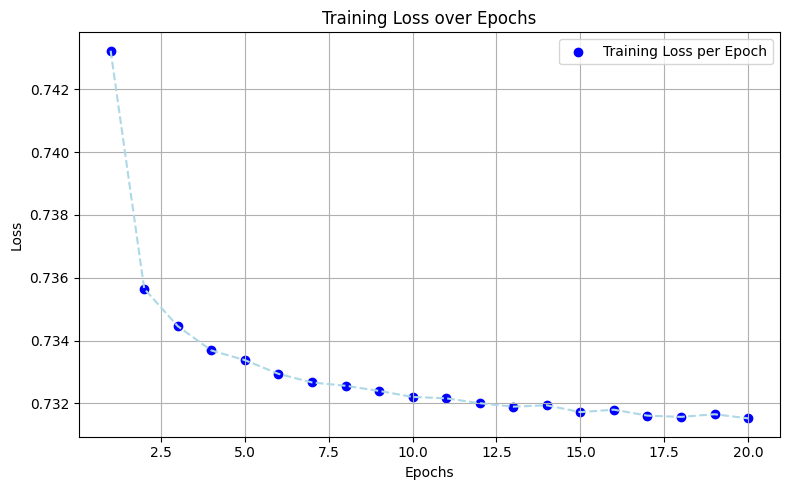

In [ ]:
plot_train_loss(solo_trainer_a, 50)

# **EVALUATION**

##### Helper Functions

In [23]:
from segmentation_trainer import extract_features

with torch.no_grad():
    for tgt, _ in val_loader:
        tgt = tgt.to(device)
        image_np = tgt[0].detach().cpu().permute(1, 2, 0).numpy().clip(0, 1)
        break

def show_masks(masks):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for ax in axes[1:]:
        ax.axis("off")

    for k in range(10):
        mask_np = masks[0, k].detach().cpu().numpy()
        axes[k].imshow(mask_np, cmap='gray')
        axes[k].set_title(f"Mask {k+1}")
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()


def val_results(obj_seg):
    obj_seg.eval()

    feats = extract_features(dino, tgt)
    masks = obj_seg(feats)

    show_masks(masks)

#### Sample Image

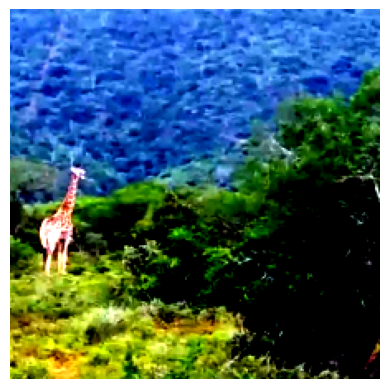

In [15]:
plt.imshow(image_np)
plt.axis('off')
plt.show()

## Version A: Solo Trained

### LR = 1e-4

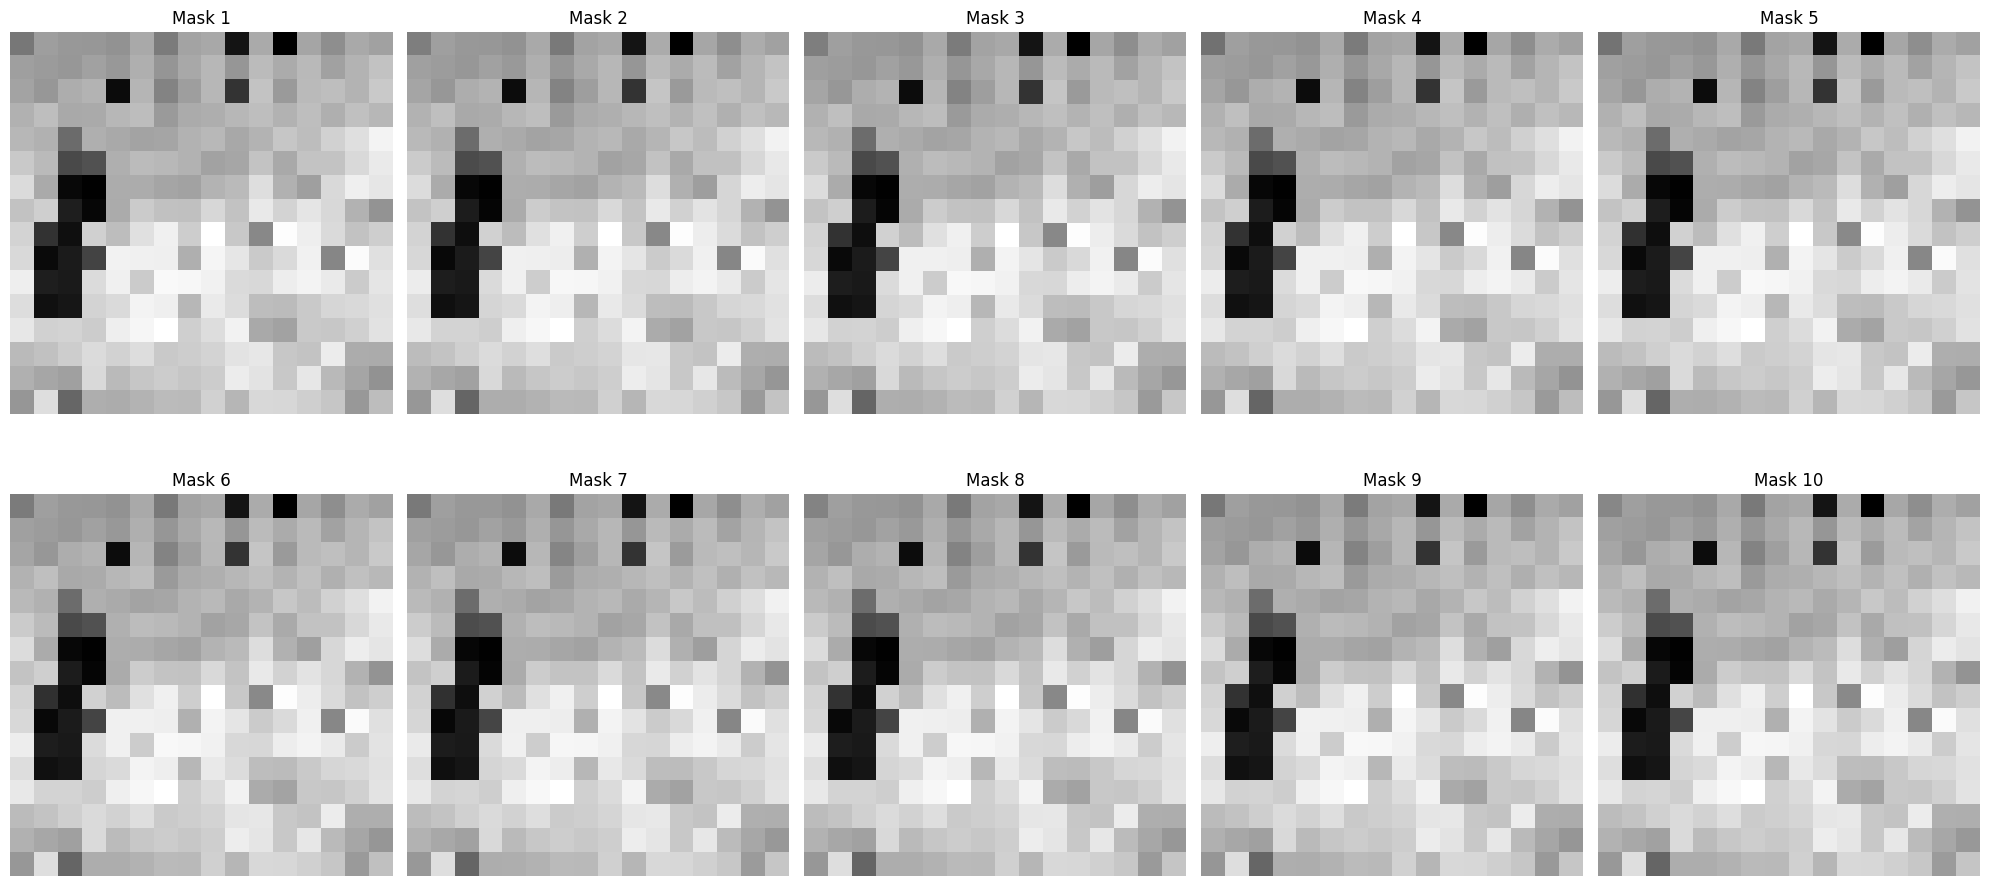

In [22]:
val_results(solo_obj_detector_a)

### LR = 1e-3

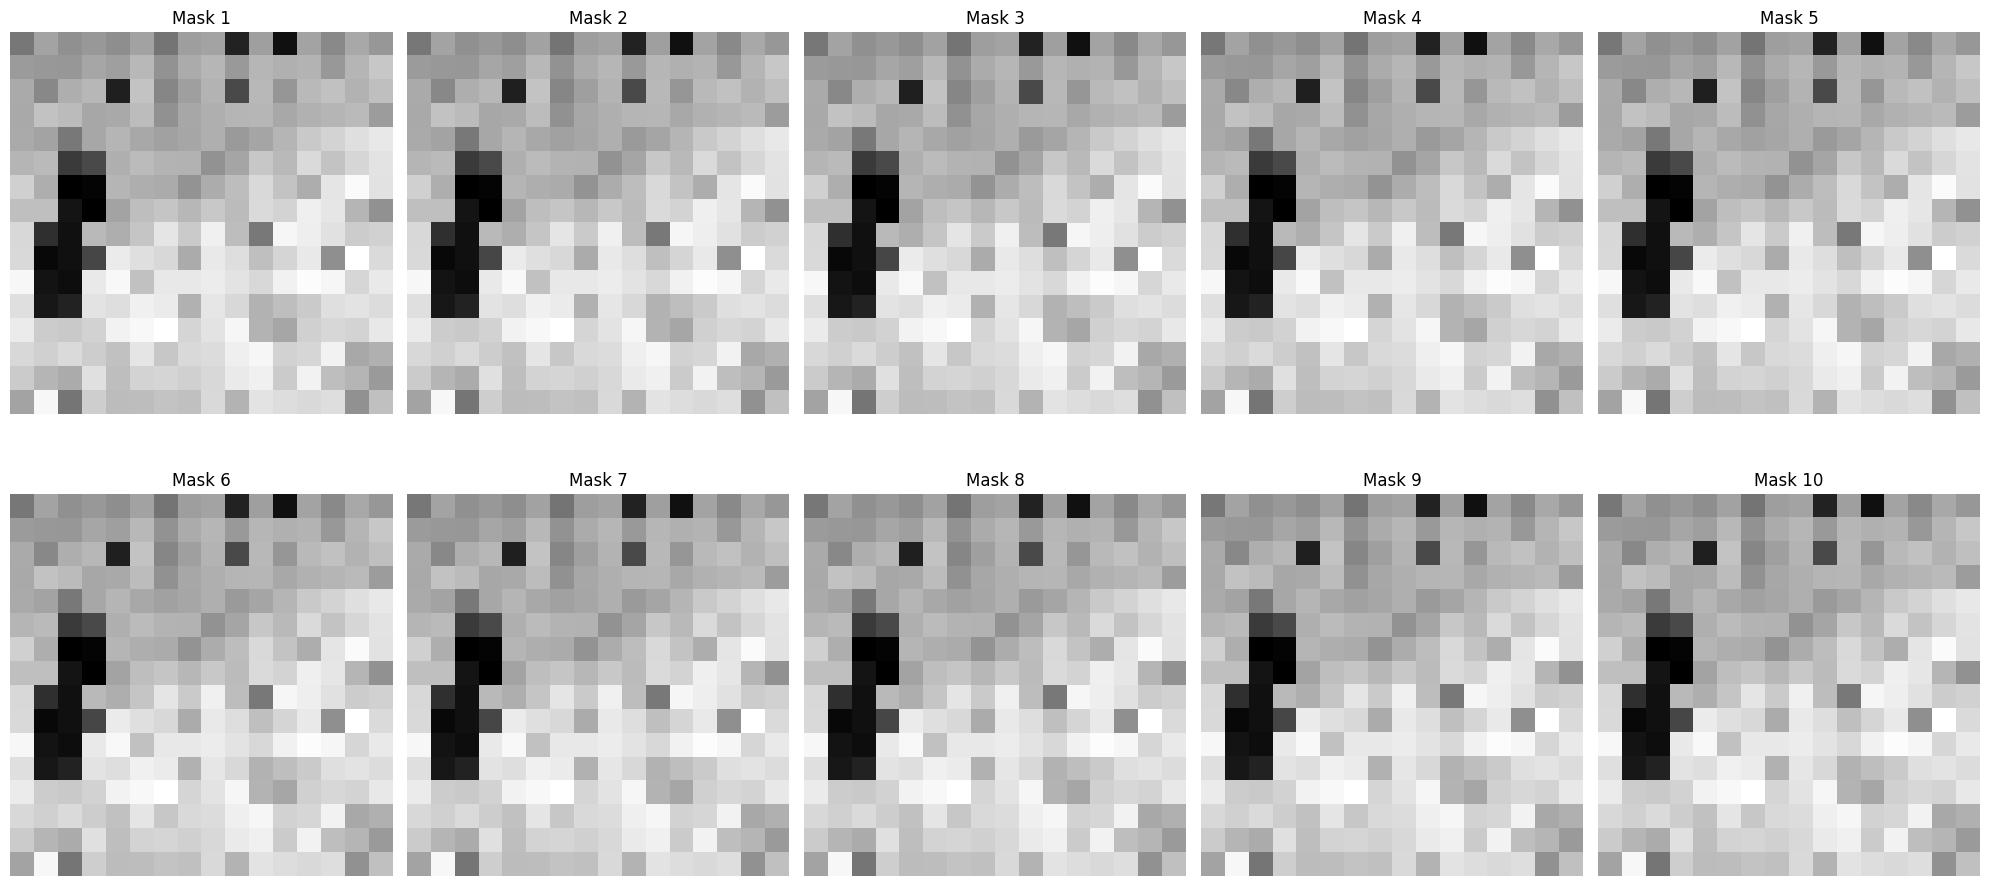

In [27]:
val_results(solo_obj_detector_b)

### LR = 1e-2

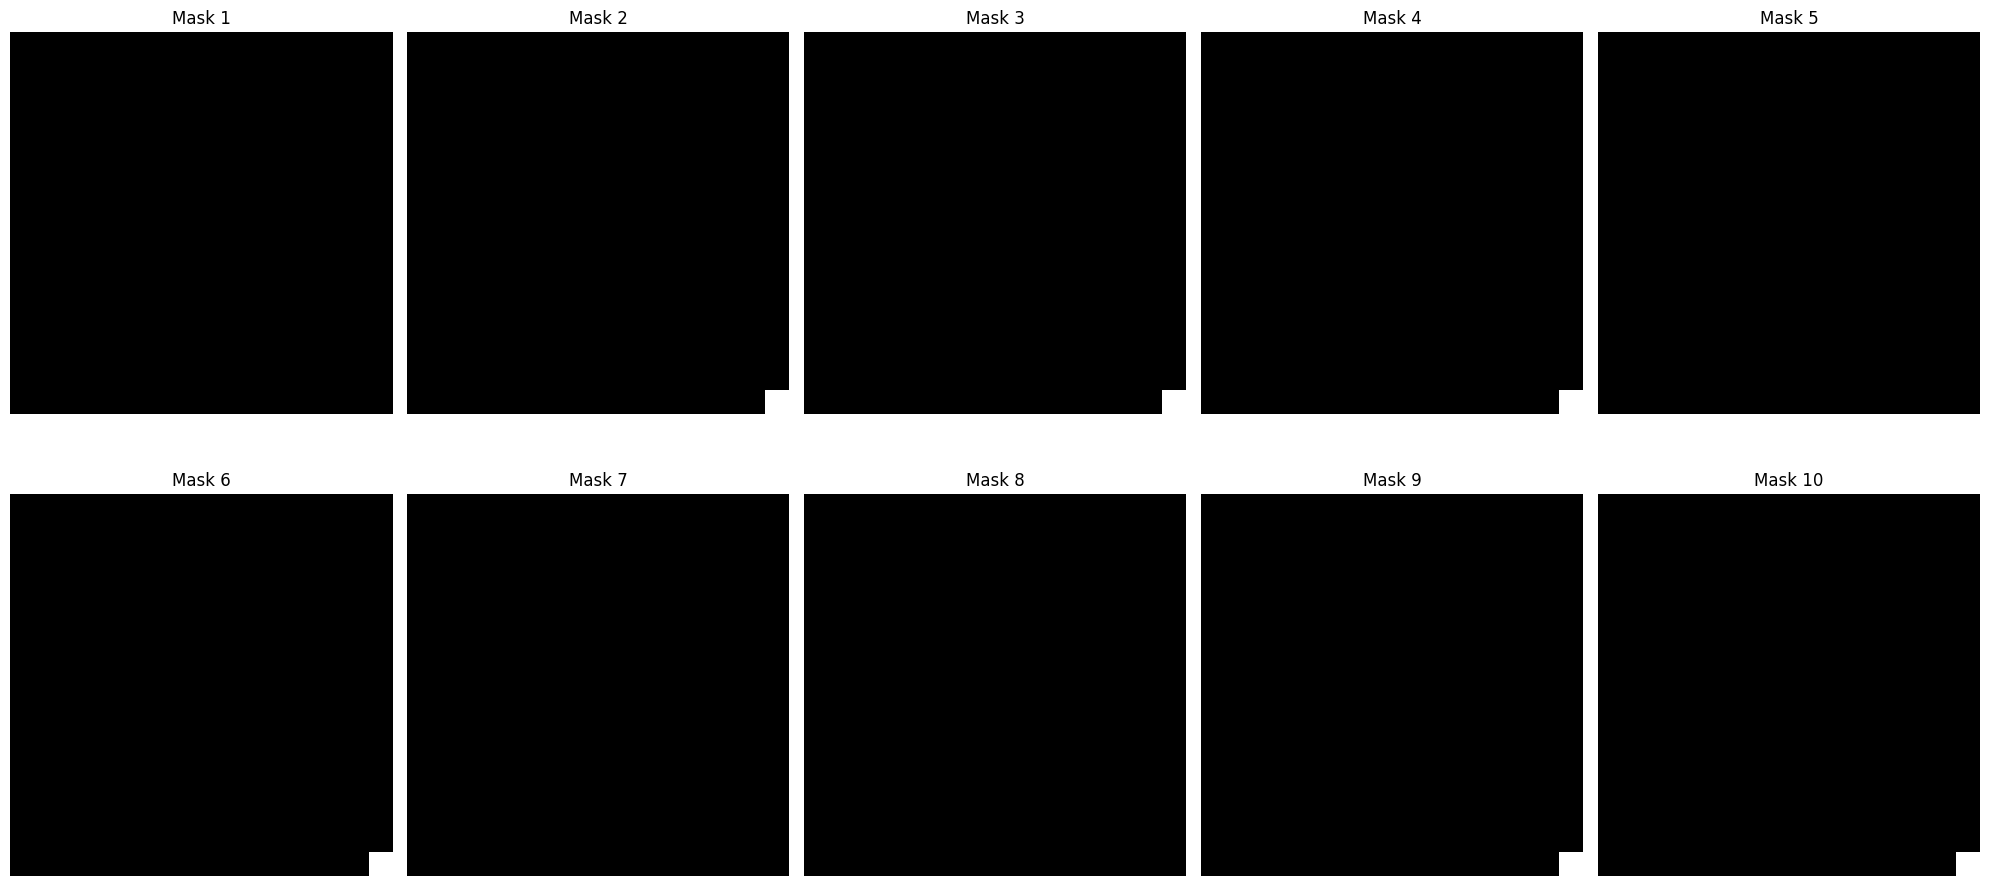

In [32]:
val_results(solo_obj_detector_c)

## Version B: Trained with Pretrained Depth Estimator

### LR = 5e-4

In [ ]:
val_results(wd_obj_detector_a)

### LR = 5e-3

In [ ]:
val_results(wd_obj_detector_b)

### LR = 1e-2

In [ ]:
val_results(wd_obj_detector_c)

## Version C: Joint Trained

### LR = 1e-3

### LR = 5e-3

### LR = 1e-2